In [73]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.preprocessing import imputation
from tqdm import tqdm
import gc
from numba import jit
from matplotlib import pyplot as plt

In [27]:
def _clean(x, default='float'):   
    non_default = 'int' if default=='float' else 'float'
    try:
        x.replace([np.inf, -np.inf], np.nan, inplace=True)
        x.dropna(how='all', axis=1, inplace=True)
        if default=='float':
            x = x * 1.0
        else:
            x = x * 1
    except Exception as e:
        print(e)
        for col in x.columns:
            if 'object' in str(x[col].dtypes):
                try:
                    x[col] = x[col].astype(default)
                except:
                    try:
                        x[col] = x[col].astype(non_default)
                    except:
                        print(col)
                        x[col] = x[col].astype('category')
    return x

def get_transposed(df, NameRow='GenX', prefix='GenX'):
    transposed  = df.T
    new_index = transposed.loc[[NameRow]].values.tolist()[0]
    transposed.columns = new_index
    if prefix is not None:
        transposed.columns = [prefix+'_'+_col for _col in transposed.columns.values.tolist()]
    return transposed.drop(NameRow, axis=0, inplace=False)

# def _impute(df, type='FM):
#   # use similarity to replace missing values with values for most similar patients.

from sklearn.ensemble import IsolationForest
def _remove_outliers(x, method='isoforest'):
    '''
    x: pandas data frame or numpy array
    method: isoforest 
    '''
    if method=='isoforest': 
        # isolation forest       
        model = IsolationForest(n_estimators=100,)
    
    # consider Angle Based Outlier Detection
    # consider using sample aggregate of z-scores
    return x
    
def _distance_significance(x,y, method='MWU'):
    # difference between distributions
    #
    # consider 1st (EMD) and 2nd (Cramer Von Mises) Wasserstein distance --> equal to area between CDF's for 1D distro's
    # consider Kolmogorov-Smirnov
    # consider MW-U
    # consider modified z-scores
    # consider quantiles
    # consider Kruskal Wallis
    # diff per feature, per sample -> expensive
    # scipy.stats import wasserstein_distance
    # scipy.stats import energy_distance
    # Kullback-Leibler divergence, Jensen-Shannon divergence
    
    return True

def _dimension_reduction(x, method='PCA', dimension=3):
    # method: PCA, SAE, UMAP

    return True   
    
                     
def _outliers_modified_z_score(ys, threshold = 3.5):
    median_y = np.median(ys)
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ys])
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y
                         for y in ys]
    return modified_z_scores, np.where(np.abs(modified_z_scores) > threshold)
    

In [18]:
pheno_small = pd.read_csv("../_docs/Lung_Phenotype_Metadata.txt", sep="\t")
pheno_large = pd.read_csv("../_docs/Lung_Table_Phenotypes.txt", sep="\t")
pheno_large.set_index('submitter_id.samples', inplace=True)

In [111]:
gc.collect()
sourceDir = "/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2" # "/media/bramvanes/Extra/DATA/RexR/2018" #  #"/media/bramvanes/Extra/DATA/RexR/2018" #
methylation = pd.read_table(sourceDir+"/Lung/Lung_Methylation.txt", sep="\t")

In [112]:
affx_labels = list(methylation.set_index('Gene').filter(axis=0, regex=r"^(AFFX.*)").index) # AFFX 
methylation = methylation.drop(affx_labels, axis=0)

methylation = methylation[np.isfinite(methylation.Start)]
methylation = methylation[np.isfinite(methylation.Stop)]

methylation.Start = methylation.Start.astype(int).astype(str)
methylation.Stop = methylation.Stop.astype(int).astype(str)
methylation.Chr = methylation.Chr.astype(str)
methylation.Gene = methylation.Gene.astype(str)

methylation['GenX'] = methylation[['Gene', 'Chr', 'Start', 'Stop']].apply(lambda x: '.'.join(x), axis=1)
_map_RNA = methylation[['Gene', 'GenX']]
methylation = methylation.drop(['Gene', 'Chr', 'Start', 'Stop'], axis=1)
methylation.dropna(thresh=10, axis=0, inplace=True)

# remove duplicate GenX values
methylation = methylation.copy().loc[~methylation.GenX.duplicated(keep='first')]
methylation.set_index('probeID', inplace=True)

dict_methylation={'Methylation_Strand_plus_CpG_Island': _clean(get_transposed(methylation.loc[(methylation.Strand=="+")
                            & (methylation.Relation_CpG_Island=='Island')]\
                              .drop(['Strand', 'Relation_CpG_Island'], axis=1))),
                  'Methylation_Strand_plus_CpG_Nshelf': _clean(get_transposed(methylation.loc[(methylation.Strand=="+")
                            & (methylation.Relation_CpG_Island=='N_Shelf')]\
                              .drop(['Strand', 'Relation_CpG_Island'], axis=1))),
                  'Methylation_Strand_plus_CpG_Nshore': _clean(get_transposed(methylation.loc[(methylation.Strand=="+")
                            & (methylation.Relation_CpG_Island=='N_Shore')]\
                              .drop(['Strand', 'Relation_CpG_Island'], axis=1))),                  
                  'Methylation_Strand_plus_CpG_Sshelf': _clean(get_transposed(methylation.loc[(methylation.Strand=="+")
                            & (methylation.Relation_CpG_Island=='S_Shelf')]\
                              .drop(['Strand', 'Relation_CpG_Island'], axis=1))),
                  'Methylation_Strand_plus_CpG_Sshore': _clean(get_transposed(methylation.loc[(methylation.Strand=="+")
                            & (methylation.Relation_CpG_Island=='S_Shore')]\
                              .drop(['Strand', 'Relation_CpG_Island'], axis=1))),
                  'Methylation_Strand_plus_CpG_NaN': _clean(get_transposed(methylation.loc[(methylation.Strand=="+")
                            & (methylation.Relation_CpG_Island.isna())]\
                              .drop(['Strand', 'Relation_CpG_Island'], axis=1))),  
                  'Methylation_Strand_min_CpG_Island': _clean(get_transposed(methylation.loc[(methylation.Strand=="-")
                            & (methylation.Relation_CpG_Island=='Island')]\
                              .drop(['Strand', 'Relation_CpG_Island'], axis=1))),
                  'Methylation_Strand_min_CpG_Nshelf': _clean(get_transposed(methylation.loc[(methylation.Strand=="-")
                            & (methylation.Relation_CpG_Island=='N_Shelf')]\
                              .drop(['Strand', 'Relation_CpG_Island'], axis=1))),
                  'Methylation_Strand_min_CpG_Nshore': _clean(get_transposed(methylation.loc[(methylation.Strand=="-")
                            & (methylation.Relation_CpG_Island=='N_Shore')]\
                              .drop(['Strand', 'Relation_CpG_Island'], axis=1))),                  
                  'Methylation_Strand_min_CpG_Sshelf': _clean(get_transposed(methylation.loc[(methylation.Strand=="-")
                            & (methylation.Relation_CpG_Island=='S_Shelf')]\
                              .drop(['Strand', 'Relation_CpG_Island'], axis=1))),
                  'Methylation_Strand_min_CpG_Sshore': _clean(get_transposed(methylation.loc[(methylation.Strand=="-")
                            & (methylation.Relation_CpG_Island=='S_Shore')]\
                              .drop(['Strand', 'Relation_CpG_Island'], axis=1))),
                  'Methylation_Strand_min_CpG_NaN': _clean(get_transposed(methylation.loc[(methylation.Strand=="-")
                            & (methylation.Relation_CpG_Island.isna())]\
                              .drop(['Strand', 'Relation_CpG_Island'], axis=1))),                    
                 }

In [32]:
# CLEAN MEMORY
del methylation
gc.collect()

14

In [33]:
# merge with phenotypes
pheno_features = ['batch_number', 'code.tissue_source_site', 'sample_type.samples', 'vial_number', 'ethnicity.demographic', 'gender.demographic',
                   'race.demographic', 'year_of_birth.demographic', 'diagnosis']

In [114]:
for _key in dict_methylation.keys():
    dict_methylation[_key] = dict_methylation[_key].copy().merge(pheno_large[pheno_features], how='left', left_index=True, right_index=True)
    gene_columns = [_col for _col in dict_methylation[_key].columns if 'GenX' in _col]
    other_columns = [_col for _col in dict_methylation[_key].columns if 'GenX' not in _col]

    dict_methylation[_key]['patient_nr'] = dict_methylation[_key].index
    tmp_min = dict_methylation[_key][['patient_nr']+gene_columns].groupby(by='patient_nr').mean()
    dict_methylation[_key] = dict_methylation[_key].copy()[other_columns].merge(tmp_min, 
                                                                                how='right',
                                                                                left_index=True, 
                                                                                right_on='patient_nr')
    dict_methylation[_key] = dict_methylation[_key].loc[~dict_methylation[_key].index.duplicated(keep='first')]

# Bias correction functions
## L/S, cohort-based normalisation

Mean-based $$\mathbf{x}^*=\frac{\mathbf{x}-\overline{\mathbf{x}}}{\sigma}$$


Median-based $$\mathbf{x}^*=\frac{\mathbf{x}-median(\mathbf{x})}{IQR}$$






In [75]:
# L/S
def _preprocess(df, cohorts = [], 
                scaler = "standard", 
                bias_removal = False, 
                col_range = None, 
                min_cohort_size=10, 
                debug=False,
                imputer=None):
        '''
         imputer: mean, median, most_frequent
        
        '''
    
        if col_range is None:
            gene_columns = [_col for _col in df.columns if 'GenX' in _col]  
        else:                      
            cr = range(col_range[0], col_range[1])
            gene_columns = df.columns[cr]
        
        if len(cohorts)==0:
            cohorts = df.batch_number.unique().tolist()
        
        # MinMaxScaler(), MaxAbsScaler(), RobustScaler(), QuantileTransformer(), Normalizer()
        if scaler == "standard":
            scaler = preprocessing.StandardScaler(with_mean=True, with_std=True)
        elif scaler == "minmax":
            scaler = preprocessing.MinMaxScaler()
        elif scaler == "maxabs":
            scaler = preprocessing.MaxAbsScaler()
        elif scaler == "robust":
            scaler = preprocessing.RobustScaler(quantile_range=(25.0, 75.0), 
                                                    with_scaling=True, with_centering=True)
        elif scaler in ["normalizer", "normaliser"]:
            scaler = preprocessing.Normalizer()

        if bias_removal == True:
            print("- "*30, 'Removing cohort biases')
            i=0; itot=len(cohorts)
            
            for cohort in cohorts: # easy to parallelise...use numpy and pooling...
                i+=1
                ch = df['batch_number']==cohort
                if sum(ch)<min_cohort_size:
                    print("Skipping cohort {}, because of low sample count: {}".format(cohort, sum(ch)))
                else:
                    if debug==False:
                        try:
                            if imputer is not None:                                
                                imp = imputation.Imputer(strategy=imputer, axis=0)
                                res = scaler.fit_transform(imp.fit_transform(df.loc[ch,gene_columns].values))
                            else:
                                res = scaler.fit_transform(df.loc[ch,gene_columns].values)
                            df.loc[ch,gene_columns] = pd.DataFrame(data=res, index=ch[ch].index, columns=gene_columns)
                            print("{}/{}, Corrected cohort {}, with {} samples".format(i, itot, cohort, sum(ch))) 
                        except Exception as e:
                            print("ERROR", e, "cohort:"+cohort)
                            print("index:",ch)
                            print("target:", df.loc[ch,gene_columns].shape) 
                            print("replacement:", res.shape)
                    else:
                        for _col in gene_columns: # for debugging
                            df_temp = df.loc[ch, _col].copy() 
                            try:
                                df.loc[ch, _col] = (df_temp-df_temp.mean())/df_temp.std()
                            except Exception as e:
                                print("ERROR", e, "gene:"+_col, "cohort:"+cohort)
        else:
            ch = df["array-batch"].isin(cohorts)
            df.loc[ch,gene_columns] = scaler.fit_transform(df.loc[ch,gene_columns])
            

        df = df[df["batch_number"].isin(cohorts)]
        return df  
    
def _quantile_normalisation():
    return True

In [69]:
for _key in dict_methylation:
    df = dict_methylation[_key]
    gene_columns = [_col for _col in df.columns if 'GenX' in _col] 
    na_cols = df.loc[df.batch_number=='119.75.0', gene_columns].isnull().any(axis=0).sum()
    avg_na_per_col = df.loc[df.batch_number=='119.75.0', gene_columns].isna().sum().sum()/na_cols
    tot_cols = len(gene_columns)

    print("For {}; there are {} columns out of {} cols with an average of {} rows with NA's \n".format(_key, na_cols, tot_cols, avg_na_per_col))

For Methylation_Strand_plus_CpG_Island; there are 1410 columns out of 41370 cols with an average of 3.4695035460992907 rows with NA's 

For Methylation_Strand_plus_CpG_Nshelf; there are 220 columns out of 6339 cols with an average of 2.359090909090909 rows with NA's 

For Methylation_Strand_plus_CpG_Nshore; there are 675 columns out of 16866 cols with an average of 3.677037037037037 rows with NA's 

For Methylation_Strand_plus_CpG_Sshelf; there are 216 columns out of 5466 cols with an average of 3.4305555555555554 rows with NA's 

For Methylation_Strand_plus_CpG_Sshore; there are 512 columns out of 12790 cols with an average of 3.2265625 rows with NA's 

For Methylation_Strand_plus_CpG_NaN; there are 4280 columns out of 113592 cols with an average of 3.052803738317757 rows with NA's 

For Methylation_Strand_min_CpG_Island; there are 1380 columns out of 41794 cols with an average of 3.4521739130434783 rows with NA's 

For Methylation_Strand_min_CpG_Nshelf; there are 219 columns out of 5

We decide to simply impute the NaN's using the median.

In [76]:
# L/S correction
dict_methylation_prepped = {}
back_shift = True
for _key in tqdm(dict_methylation.keys()):
    dict_methylation_prepped[_key] = _preprocess(dict_methylation[_key], 
                                         col_range=None, 
                                         bias_removal=True, 
                                         debug=False, 
                                         scaler='standard', 
                                         imputer='median')
    if back_shift:
        # median shift back the data.. 
        gene_columns = [_col for _col in dict_methylation_prepped[_key].columns if 'GenX' in _col]    
        dict_methylation_prepped[_key].loc[:, gene_columns] *= dict_methylation[_key].loc[:, gene_columns].std(axis=0)
        dict_methylation_prepped[_key].loc[:, gene_columns] += dict_methylation[_key].loc[:, gene_columns].median(axis=0)


  0%|          | 0/12 [00:00<?, ?it/s]

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Removing cohort biases
1/38, Corrected cohort 119.75.0, with 62 samples
2/38, Corrected cohort 144.69.0, with 39 samples
3/38, Corrected cohort 84.72.0, with 33 samples
4/38, Corrected cohort 77.67.0, with 48 samples
5/38, Corrected cohort 101.61.0, with 38 samples
Skipping cohort 208.52.0, because of low sample count: 7
7/38, Corrected cohort 283.49.0, with 48 samples
8/38, Corrected cohort 140.61.0, with 32 samples
9/38, Corrected cohort 193.55.0, with 30 samples
10/38, Corrected cohort 159.57.0, with 17 samples
11/38, Corrected cohort 293.49.0, with 25 samples
Skipping cohort nan, because of low sample count: 0
13/38, Corrected cohort 276.50.0, with 21 samples
ERROR Shape of passed values is (41366, 11), indices imply (41370, 11) cohort:415.35.0
index: patient_nr
TCGA-05-4384-01    False
TCGA-05-4390-01    False
TCGA-05-4396-01    False
TCGA-05-4405-01    False
TCGA-05-4410-01    False
TCGA-05-4415-01    False
TCGA-05-4417


  8%|▊         | 1/12 [09:29<1:44:23, 569.38s/it]

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Removing cohort biases
1/38, Corrected cohort 119.75.0, with 62 samples
2/38, Corrected cohort 144.69.0, with 39 samples
3/38, Corrected cohort 84.72.0, with 33 samples
4/38, Corrected cohort 77.67.0, with 48 samples
5/38, Corrected cohort 101.61.0, with 38 samples
Skipping cohort 208.52.0, because of low sample count: 7
7/38, Corrected cohort 283.49.0, with 48 samples
8/38, Corrected cohort 140.61.0, with 32 samples
9/38, Corrected cohort 193.55.0, with 30 samples
10/38, Corrected cohort 159.57.0, with 17 samples
11/38, Corrected cohort 293.49.0, with 25 samples
Skipping cohort nan, because of low sample count: 0
13/38, Corrected cohort 276.50.0, with 21 samples
14/38, Corrected cohort 415.35.0, with 11 samples
15/38, Corrected cohort 233.50.0, with 15 samples
16/38, Corrected cohort 166.66.0, with 33 samples
17/38, Corrected cohort 258.58.0, with 34 samples
Skipping cohort 39.67.0, because of low sample count: 2
19/38, Corr


 17%|█▋        | 2/12 [11:02<55:14, 331.44s/it]  

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Removing cohort biases
1/38, Corrected cohort 119.75.0, with 62 samples
2/38, Corrected cohort 144.69.0, with 39 samples
3/38, Corrected cohort 84.72.0, with 33 samples
4/38, Corrected cohort 77.67.0, with 48 samples
5/38, Corrected cohort 101.61.0, with 38 samples
Skipping cohort 208.52.0, because of low sample count: 7
7/38, Corrected cohort 283.49.0, with 48 samples
8/38, Corrected cohort 140.61.0, with 32 samples
9/38, Corrected cohort 193.55.0, with 30 samples
10/38, Corrected cohort 159.57.0, with 17 samples
11/38, Corrected cohort 293.49.0, with 25 samples
Skipping cohort nan, because of low sample count: 0
13/38, Corrected cohort 276.50.0, with 21 samples
14/38, Corrected cohort 415.35.0, with 11 samples
15/38, Corrected cohort 233.50.0, with 15 samples
16/38, Corrected cohort 166.66.0, with 33 samples
17/38, Corrected cohort 258.58.0, with 34 samples
Skipping cohort 39.67.0, because of low sample count: 2
19/38, Corr


 25%|██▌       | 3/12 [15:08<45:24, 302.76s/it]

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Removing cohort biases
1/38, Corrected cohort 119.75.0, with 62 samples
2/38, Corrected cohort 144.69.0, with 39 samples
3/38, Corrected cohort 84.72.0, with 33 samples
4/38, Corrected cohort 77.67.0, with 48 samples
5/38, Corrected cohort 101.61.0, with 38 samples
Skipping cohort 208.52.0, because of low sample count: 7
7/38, Corrected cohort 283.49.0, with 48 samples
8/38, Corrected cohort 140.61.0, with 32 samples
9/38, Corrected cohort 193.55.0, with 30 samples
10/38, Corrected cohort 159.57.0, with 17 samples
11/38, Corrected cohort 293.49.0, with 25 samples
Skipping cohort nan, because of low sample count: 0
13/38, Corrected cohort 276.50.0, with 21 samples
14/38, Corrected cohort 415.35.0, with 11 samples
15/38, Corrected cohort 233.50.0, with 15 samples
16/38, Corrected cohort 166.66.0, with 33 samples
17/38, Corrected cohort 258.58.0, with 34 samples
Skipping cohort 39.67.0, because of low sample count: 2
19/38, Corr


 33%|███▎      | 4/12 [16:28<32:57, 247.23s/it]

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Removing cohort biases
1/38, Corrected cohort 119.75.0, with 62 samples
2/38, Corrected cohort 144.69.0, with 39 samples
3/38, Corrected cohort 84.72.0, with 33 samples
4/38, Corrected cohort 77.67.0, with 48 samples
5/38, Corrected cohort 101.61.0, with 38 samples
Skipping cohort 208.52.0, because of low sample count: 7
7/38, Corrected cohort 283.49.0, with 48 samples
8/38, Corrected cohort 140.61.0, with 32 samples
9/38, Corrected cohort 193.55.0, with 30 samples
10/38, Corrected cohort 159.57.0, with 17 samples
11/38, Corrected cohort 293.49.0, with 25 samples
Skipping cohort nan, because of low sample count: 0
13/38, Corrected cohort 276.50.0, with 21 samples
14/38, Corrected cohort 415.35.0, with 11 samples
15/38, Corrected cohort 233.50.0, with 15 samples
16/38, Corrected cohort 166.66.0, with 33 samples
17/38, Corrected cohort 258.58.0, with 34 samples
Skipping cohort 39.67.0, because of low sample count: 2
19/38, Corr


 42%|████▏     | 5/12 [19:36<27:26, 235.25s/it]

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Removing cohort biases
1/38, Corrected cohort 119.75.0, with 62 samples
2/38, Corrected cohort 144.69.0, with 39 samples
3/38, Corrected cohort 84.72.0, with 33 samples
4/38, Corrected cohort 77.67.0, with 48 samples
5/38, Corrected cohort 101.61.0, with 38 samples
Skipping cohort 208.52.0, because of low sample count: 7
7/38, Corrected cohort 283.49.0, with 48 samples
8/38, Corrected cohort 140.61.0, with 32 samples
9/38, Corrected cohort 193.55.0, with 30 samples
10/38, Corrected cohort 159.57.0, with 17 samples
11/38, Corrected cohort 293.49.0, with 25 samples
Skipping cohort nan, because of low sample count: 0
13/38, Corrected cohort 276.50.0, with 21 samples
ERROR Shape of passed values is (113577, 11), indices imply (113592, 11) cohort:415.35.0
index: patient_nr
TCGA-05-4384-01    False
TCGA-05-4390-01    False
TCGA-05-4396-01    False
TCGA-05-4405-01    False
TCGA-05-4410-01    False
TCGA-05-4415-01    False
TCGA-05-44


 50%|█████     | 6/12 [44:37<44:37, 446.25s/it]

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Removing cohort biases
1/38, Corrected cohort 119.75.0, with 62 samples
2/38, Corrected cohort 144.69.0, with 39 samples
3/38, Corrected cohort 84.72.0, with 33 samples
4/38, Corrected cohort 77.67.0, with 48 samples
5/38, Corrected cohort 101.61.0, with 38 samples
Skipping cohort 208.52.0, because of low sample count: 7
7/38, Corrected cohort 283.49.0, with 48 samples
8/38, Corrected cohort 140.61.0, with 32 samples
9/38, Corrected cohort 193.55.0, with 30 samples
10/38, Corrected cohort 159.57.0, with 17 samples
11/38, Corrected cohort 293.49.0, with 25 samples
Skipping cohort nan, because of low sample count: 0
13/38, Corrected cohort 276.50.0, with 21 samples
ERROR Shape of passed values is (41793, 11), indices imply (41794, 11) cohort:415.35.0
index: patient_nr
TCGA-05-4384-01    False
TCGA-05-4390-01    False
TCGA-05-4396-01    False
TCGA-05-4405-01    False
TCGA-05-4410-01    False
TCGA-05-4415-01    False
TCGA-05-4417


 58%|█████▊    | 7/12 [54:25<38:52, 466.51s/it]

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Removing cohort biases
1/38, Corrected cohort 119.75.0, with 62 samples
2/38, Corrected cohort 144.69.0, with 39 samples
3/38, Corrected cohort 84.72.0, with 33 samples
4/38, Corrected cohort 77.67.0, with 48 samples
5/38, Corrected cohort 101.61.0, with 38 samples
Skipping cohort 208.52.0, because of low sample count: 7
7/38, Corrected cohort 283.49.0, with 48 samples
8/38, Corrected cohort 140.61.0, with 32 samples
9/38, Corrected cohort 193.55.0, with 30 samples
10/38, Corrected cohort 159.57.0, with 17 samples
11/38, Corrected cohort 293.49.0, with 25 samples
Skipping cohort nan, because of low sample count: 0
13/38, Corrected cohort 276.50.0, with 21 samples
ERROR Shape of passed values is (5945, 11), indices imply (5946, 11) cohort:415.35.0
index: patient_nr
TCGA-05-4384-01    False
TCGA-05-4390-01    False
TCGA-05-4396-01    False
TCGA-05-4405-01    False
TCGA-05-4410-01    False
TCGA-05-4415-01    False
TCGA-05-4417-0


 67%|██████▋   | 8/12 [55:51<27:55, 418.89s/it]

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Removing cohort biases
1/38, Corrected cohort 119.75.0, with 62 samples
2/38, Corrected cohort 144.69.0, with 39 samples
3/38, Corrected cohort 84.72.0, with 33 samples
4/38, Corrected cohort 77.67.0, with 48 samples
5/38, Corrected cohort 101.61.0, with 38 samples
Skipping cohort 208.52.0, because of low sample count: 7
7/38, Corrected cohort 283.49.0, with 48 samples
8/38, Corrected cohort 140.61.0, with 32 samples
9/38, Corrected cohort 193.55.0, with 30 samples
10/38, Corrected cohort 159.57.0, with 17 samples
11/38, Corrected cohort 293.49.0, with 25 samples
Skipping cohort nan, because of low sample count: 0
13/38, Corrected cohort 276.50.0, with 21 samples
14/38, Corrected cohort 415.35.0, with 11 samples
15/38, Corrected cohort 233.50.0, with 15 samples
16/38, Corrected cohort 166.66.0, with 33 samples
17/38, Corrected cohort 258.58.0, with 34 samples
Skipping cohort 39.67.0, because of low sample count: 2
19/38, Corr


 75%|███████▌  | 9/12 [59:51<19:57, 399.06s/it]

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Removing cohort biases
1/38, Corrected cohort 119.75.0, with 62 samples
2/38, Corrected cohort 144.69.0, with 39 samples
3/38, Corrected cohort 84.72.0, with 33 samples
4/38, Corrected cohort 77.67.0, with 48 samples
5/38, Corrected cohort 101.61.0, with 38 samples
Skipping cohort 208.52.0, because of low sample count: 7
7/38, Corrected cohort 283.49.0, with 48 samples
8/38, Corrected cohort 140.61.0, with 32 samples
9/38, Corrected cohort 193.55.0, with 30 samples
10/38, Corrected cohort 159.57.0, with 17 samples
11/38, Corrected cohort 293.49.0, with 25 samples
Skipping cohort nan, because of low sample count: 0
13/38, Corrected cohort 276.50.0, with 21 samples
14/38, Corrected cohort 415.35.0, with 11 samples
15/38, Corrected cohort 233.50.0, with 15 samples
16/38, Corrected cohort 166.66.0, with 33 samples
17/38, Corrected cohort 258.58.0, with 34 samples
Skipping cohort 39.67.0, because of low sample count: 2
19/38, Corr


 83%|████████▎ | 10/12 [1:01:17<12:15, 367.80s/it]

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Removing cohort biases
1/38, Corrected cohort 119.75.0, with 62 samples
2/38, Corrected cohort 144.69.0, with 39 samples
3/38, Corrected cohort 84.72.0, with 33 samples
4/38, Corrected cohort 77.67.0, with 48 samples
5/38, Corrected cohort 101.61.0, with 38 samples
Skipping cohort 208.52.0, because of low sample count: 7
7/38, Corrected cohort 283.49.0, with 48 samples
8/38, Corrected cohort 140.61.0, with 32 samples
9/38, Corrected cohort 193.55.0, with 30 samples
10/38, Corrected cohort 159.57.0, with 17 samples
11/38, Corrected cohort 293.49.0, with 25 samples
Skipping cohort nan, because of low sample count: 0
13/38, Corrected cohort 276.50.0, with 21 samples
ERROR Shape of passed values is (12903, 11), indices imply (12906, 11) cohort:415.35.0
index: patient_nr
TCGA-05-4384-01    False
TCGA-05-4390-01    False
TCGA-05-4396-01    False
TCGA-05-4405-01    False
TCGA-05-4410-01    False
TCGA-05-4415-01    False
TCGA-05-4417


 92%|█████████▏| 11/12 [1:04:22<05:51, 351.15s/it]

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Removing cohort biases
1/38, Corrected cohort 119.75.0, with 62 samples
2/38, Corrected cohort 144.69.0, with 39 samples
3/38, Corrected cohort 84.72.0, with 33 samples
4/38, Corrected cohort 77.67.0, with 48 samples
5/38, Corrected cohort 101.61.0, with 38 samples
Skipping cohort 208.52.0, because of low sample count: 7
7/38, Corrected cohort 283.49.0, with 48 samples
8/38, Corrected cohort 140.61.0, with 32 samples
9/38, Corrected cohort 193.55.0, with 30 samples
10/38, Corrected cohort 159.57.0, with 17 samples
11/38, Corrected cohort 293.49.0, with 25 samples
Skipping cohort nan, because of low sample count: 0
13/38, Corrected cohort 276.50.0, with 21 samples
ERROR Shape of passed values is (114502, 11), indices imply (114514, 11) cohort:415.35.0
index: patient_nr
TCGA-05-4384-01    False
TCGA-05-4390-01    False
TCGA-05-4396-01    False
TCGA-05-4405-01    False
TCGA-05-4410-01    False
TCGA-05-4415-01    False
TCGA-05-44


100%|██████████| 12/12 [1:30:25<00:00, 452.13s/it]


Text(0.5,1,'Cohort comparison for GenX_MUC5B.chr11.1230961.1230963 (+ strand) with scaling')

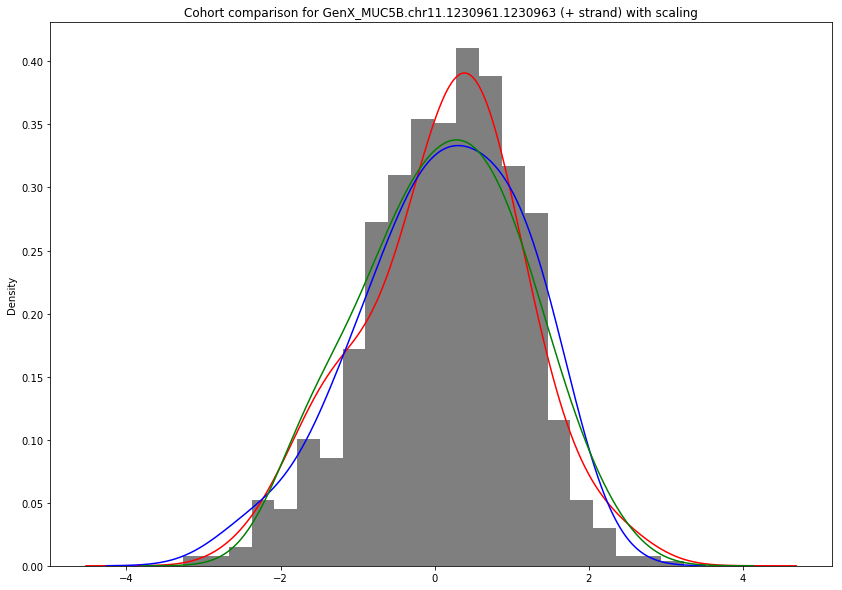

In [143]:
island='Methylation_Strand_min_CpG_Island'

test_gene = 'GenX_MUC5B.chr11.1230961.1230963'
dict_methylation_prepped[island][test_gene]\
                .plot.hist(alpha=0.5, bins=22, figsize=(14,10), color='black', density=True)
dict_methylation_prepped[island].loc[dict_methylation_prepped[island].batch_number=='101.61.0'][test_gene]\
                .plot.kde(color='red')
dict_methylation_prepped[island].loc[dict_methylation_prepped[island].batch_number=='196.63.0'][test_gene]\
                .plot.kde(color='blue')
dict_methylation_prepped[island].loc[dict_methylation_prepped[island].batch_number=='264.59.0'][test_gene]\
                .plot.kde(color='green')
plt.title('Cohort comparison for {} (+ strand) with scaling'.format(test_gene))

Text(0.5,1,'Cohort comparison for GenX_MUC5B.chr11.1230961.1230963 (+ strand) without scaling')

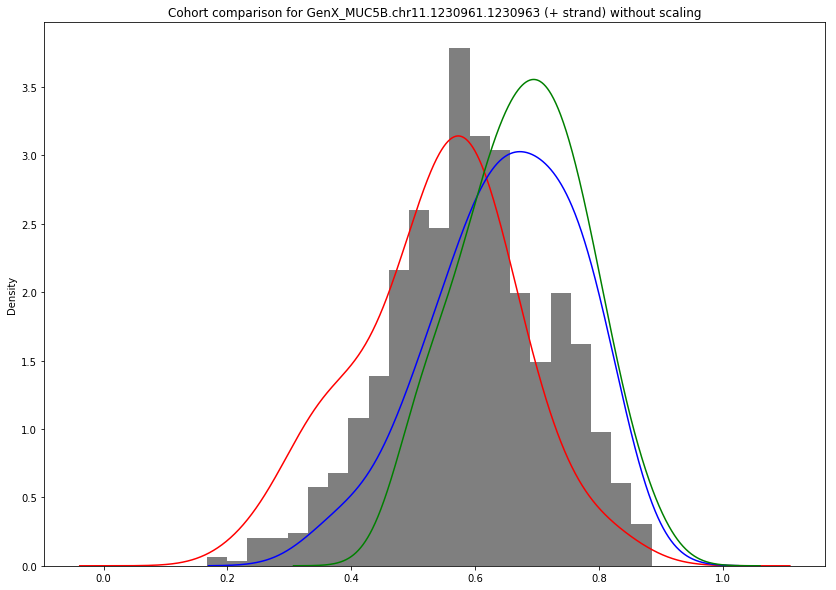

In [146]:
dict_methylation[island][test_gene]\
                .plot.hist(alpha=0.5, bins=22, figsize=(14,10), color='black', density=True)
dict_methylation[island].loc[dict_methylation[island].batch_number=='101.61.0'][test_gene]\
                .plot.kde(color='red')
dict_methylation[island].loc[dict_methylation[island].batch_number=='196.63.0'][test_gene]\
                .plot.kde(color='blue')
dict_methylation[island].loc[dict_methylation[island].batch_number=='264.59.0'][test_gene]\
                .plot.kde(color='green')
plt.title('Cohort comparison for {} (+ strand) without scaling'.format(test_gene))

In [147]:
for _key in tqdm(dict_methylation_prepped):
    dict_methylation_prepped[_key].to_csv(sourceDir+"/Lung/_prepped/"+_key+".csv.gzip",
                                          compression="gzip")



  0%|          | 0/12 [00:00<?, ?it/s]

  8%|▊         | 1/12 [02:53<31:49, 173.62s/it]

 17%|█▋        | 2/12 [03:17<16:27, 98.79s/it] 

 25%|██▌       | 3/12 [04:23<13:09, 87.76s/it]

 33%|███▎      | 4/12 [04:43<09:27, 70.99s/it]

 42%|████▏     | 5/12 [05:32<07:46, 66.59s/it]

 50%|█████     | 6/12 [14:00<14:00, 140.04s/it]

 58%|█████▊    | 7/12 [16:58<12:07, 145.49s/it]

 67%|██████▋   | 8/12 [17:25<08:42, 130.63s/it]

 75%|███████▌  | 9/12 [18:44<06:14, 124.91s/it]

 83%|████████▎ | 10/12 [19:11<03:50, 115.18s/it]

 92%|█████████▏| 11/12 [20:14<01:50, 110.38s/it]

100%|██████████| 12/12 [29:05<00:00, 145.46s/it]



# Cohort bias detection

a-priori and a-posteriori


In [39]:
import rpy2.robjects as robjects
import numpy as np
from rpy2.robjects.packages import importr
preprocessCore = importr('preprocessCore')


In [110]:
def _cohort_bias_detection(df, min_samples=10, n_comp=3):
    gene_columns = [_col for _col in df.columns if 'GenX' in _col]
    cohorts = df.batch_number.unique().tolist()
    red_data_dict = {}
    for _cohort in tqdm(cohorts):
        ch = df['batch_number']==_cohort
        X = df.loc[ch, gene_columns]
        if X.shape[0]>min_samples:
            # PCA 3
            reducer = decomposition.PCA(copy=True, n_components=n_comp, svd_solver='arpack')
            # put components in a dictionary with cohort as key
            X_red = reducer.fit_transform(X)
            #
            red_data_dict[_cohort] = {}
            red_data_dict[_cohort]['data'] = X_red
            red_data_dict[_cohort]['reducer'] = reducer
    
    reducer = decomposition.PCA(copy=True, n_components=n_comp, svd_solver='arpack')
    X = df.loc[:, gene_columns]
    X_red = reducer.fit_transform(X)
    red_data_dict['ALL'] = 
    
    return red_data_dict

In [97]:
merged_RNA_min_PCA = _cohort_bias_detection(merged_RNA_min)
merged_RNA_plus_PCA = _cohort_bias_detection(merged_RNA_min)
merged_RNA_min_LS_median_PCA = _cohort_bias_detection(merged_RNA_min_CBC_LS)
merged_RNA_plus_LS_median_PCA = _cohort_bias_detection(merged_RNA_plus_CBC_LS)

100%|██████████| 43/43 [00:03<00:00, 13.00it/s]


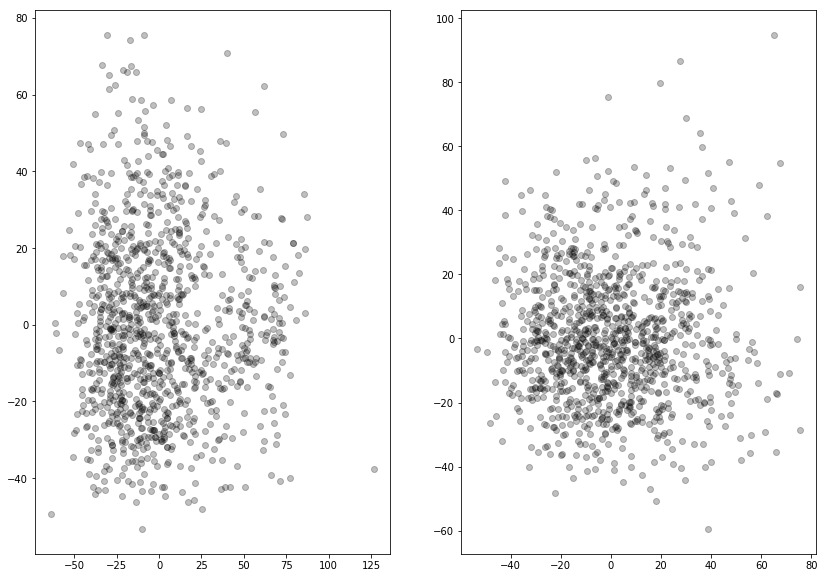

In [109]:
res_dict = merged_RNA_min_PCA

cohorts = res_dict.keys()
fig, ax = plt.subplots(ncols=2, figsize=(14,10))
for _cohort in cohorts:
    ax[0].plot(res_dict[_cohort]['data'][:,0], 
             res_dict[_cohort]['data'][:,1], 'o', color='black', alpha=0.25)
    ax[1].plot(res_dict[_cohort]['data'][:,1], 
             res_dict[_cohort]['data'][:,2], 'o', color='black', alpha=0.25)    

    